# CP5 – Modelo de Classificação com IA
### Tema: Previsão de Diabetes com Aprendizado Supervisionado
---
## 1. Definição do Problema
O objetivo é construir um modelo de **classificação supervisionado** capaz de prever se uma pessoa
tem **diabetes** (`1`) ou **não tem** (`0`), com base em dados clínicos.

### Justificativa
A identificação precoce do diabetes permite tratamentos mais eficazes e melhora da qualidade de vida.
Modelos de IA podem ajudar profissionais de saúde a detectar padrões de risco de forma automatizada.

### Tipo de problema
Classificação **binária** (`positivo` / `negativo`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 2. Descrição do Dataset
- **Fonte:** [UCI Machine Learning Repository](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
- **Registros:** 768 pacientes
- **Variáveis:** 8 atributos preditores + 1 alvo (Resultado)

| Variável | Descrição |
|-----------|------------|
| NumGravidez | Número de gestações |
| Glicose | Concentração de glicose no plasma |
| Pressao | Pressão sanguínea diastólica |
| EspessuraPele | Espessura da dobra cutânea do tríceps |
| Insulina | Nível sérico de insulina |
| IMC | Índice de Massa Corporal |
| FuncaoPedigree | Função genética de diabetes |
| Idade | Idade do paciente |
| Resultado | 1 = diabetes / 0 = não-diabetes |

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
colunas = ['NumGravidez', 'Glicose', 'Pressao', 'EspessuraPele', 'Insulina', 'IMC', 'FuncaoPedigree', 'Idade', 'Resultado']
df = pd.read_csv(url, names=colunas)
print('Dados carregados:', df.shape)
df.head()

Dados carregados: (768, 9)


,NumGravidez,Glicose,Pressao,EspessuraPele,Insulina,IMC,FuncaoPedigree,Idade,Resultado
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 3. Análise Exploratória Inicial
Nesta etapa verificamos tipos de dados, valores ausentes e distribuição das classes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NumGravidez     768 non-null    int64  
 1   Glicose         768 non-null    int64  
 2   Pressao         768 non-null    int64  
 3   EspessuraPele   768 non-null    int64  
 4   Insulina        768 non-null    int64  
 5   IMC             768 non-null    float64
 6   FuncaoPedigree  768 non-null    float64
 7   Idade           768 non-null    int64  
 8   Resultado       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


/tmp/ipython-input-931448032.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Resultado', data=df, palette='viridis')


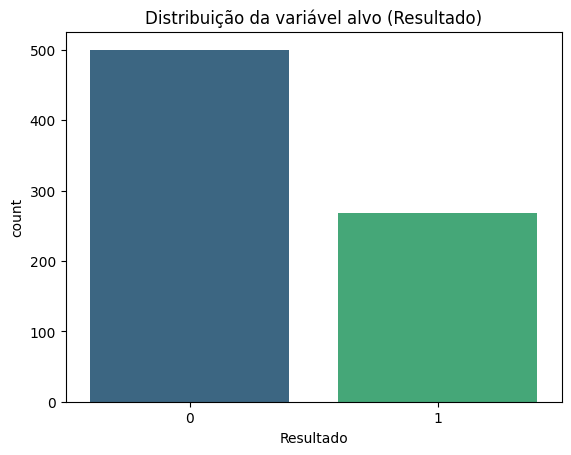

In [3]:
df.info()
df.describe()
sns.countplot(x='Resultado', data=df, palette='viridis')
plt.title('Distribuição da variável alvo (Resultado)')
plt.show()

## 4. Pré-processamento dos Dados
Valores igual a 0 em variáveis como Glicose, Pressão e IMC não são plausíveis fisiologicamente,
por isso foram tratados como ausentes e substituídos pela **mediana**, que é mais robusta a outliers.

In [4]:
cols_com_zero = ['Glicose', 'Pressao', 'EspessuraPele', 'Insulina', 'IMC']
for col in cols_com_zero:
    zeros = (df[col] == 0).sum()
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].median())
    print(f'{col}: {zeros} valores substituídos pela mediana.')

Glicose: 5 valores substituídos pela mediana.
Pressao: 35 valores substituídos pela mediana.
EspessuraPele: 227 valores substituídos pela mediana.
Insulina: 374 valores substituídos pela mediana.
IMC: 11 valores substituídos pela mediana.


### Verificação de Outliers
Mesmo que não sejam removidos, é importante avaliá-los visualmente.

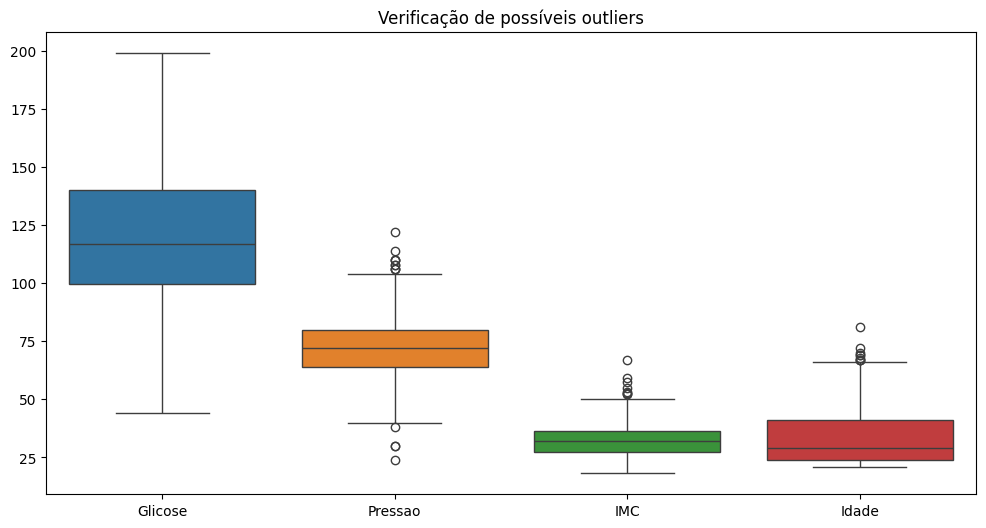

In [5]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Glicose', 'Pressao', 'IMC', 'Idade']])
plt.title('Verificação de possíveis outliers')
plt.show()

Após análise visual, optou-se **por não remover outliers**, pois representam variações reais e não distorcem significativamente as estatísticas.

In [6]:
X = df.drop('Resultado', axis=1)
y = df['Resultado']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

## 5. Visualizações Analíticas
Cada gráfico a seguir tem um propósito analítico claro, servindo para levantar hipóteses sobre relações entre variáveis.

/tmp/ipython-input-144056107.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado', y='Glicose', data=df, palette='coolwarm')


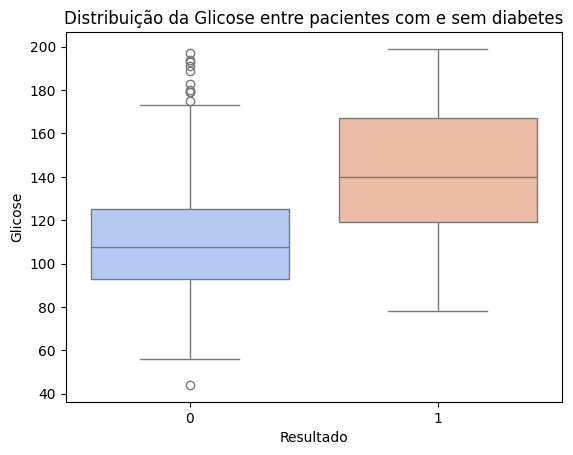

/tmp/ipython-input-144056107.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado', y='IMC', data=df, palette='coolwarm')


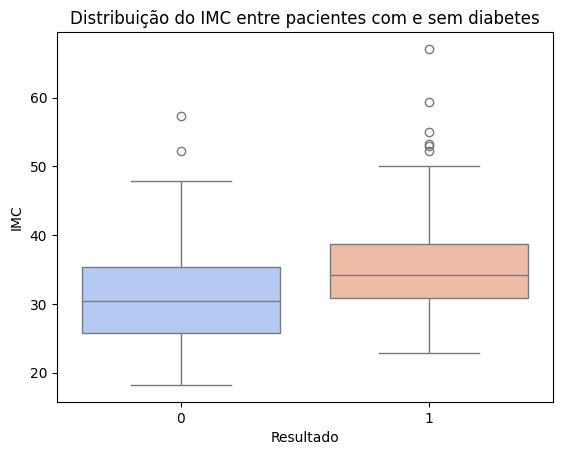

In [7]:
sns.boxplot(x='Resultado', y='Glicose', data=df, palette='coolwarm')
plt.title('Distribuição da Glicose entre pacientes com e sem diabetes')
plt.show()

sns.boxplot(x='Resultado', y='IMC', data=df, palette='coolwarm')
plt.title('Distribuição do IMC entre pacientes com e sem diabetes')
plt.show()

Observa-se que pacientes com diabetes têm valores medianos mais altos de **Glicose** e **IMC**,
o que indica relação direta entre esses fatores e o diagnóstico.

## 6. Modelagem e Justificativas
Os modelos escolhidos representam diferentes famílias:
- **Regressão Logística:** baseline linear e interpretável.
- **LDA:** analisa separabilidade de classes assumindo normalidade.
- **Random Forest:** captura interações não lineares.
- **SVM:** eficaz em espaços de alta dimensionalidade.
Comparar diferentes naturezas ajuda a identificar o algoritmo mais adequado.

In [8]:
modelos = {
    'Regressão Logística': LogisticRegression(max_iter=200),
    'LDA': LinearDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf'),
    'Árvore de Decisão': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

resultados = []
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    resultados.append([nome, acc, prec, rec, f1])

resultados_df = pd.DataFrame(resultados, columns=['Modelo','Acurácia','Precisão','Recall','F1-Score']).sort_values(by='F1-Score', ascending=False)
resultados_df

,Modelo,Acurácia,Precisão,Recall,F1-Score
3,KNN,0.748918,0.661972,0.580247,0.618421
2,Naive Bayes,0.727273,0.618421,0.580247,0.598726
0,Regressão Logística,0.744589,0.671875,0.530864,0.593103
4,SVM,0.744589,0.677419,0.518519,0.587413
6,Random Forest,0.740260,0.666667,0.518519,0.583333
1,LDA,0.735931,0.661290,0.506173,0.573427
5,Árvore de Decisão,0.688312,0.558442,0.530864,0.544304


/tmp/ipython-input-362132777.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados_df, x='Modelo', y='F1-Score', palette='viridis')


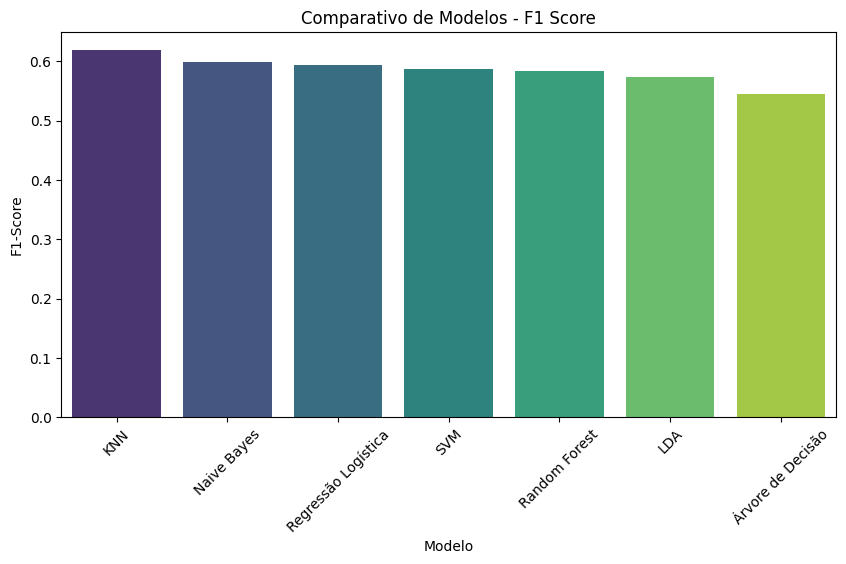

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(data=resultados_df, x='Modelo', y='F1-Score', palette='viridis')
plt.xticks(rotation=45)
plt.title('Comparativo de Modelos - F1 Score')
plt.show()

## 7. Avaliação Detalhada do Melhor Modelo
A métrica **F1-Score** foi priorizada por equilibrar precisão e recall, essencial em contextos de saúde,
onde falsos negativos são especialmente problemáticos.

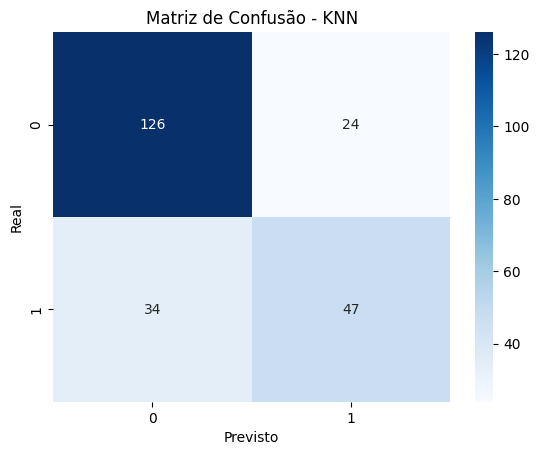

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       150
           1       0.66      0.58      0.62        81

    accuracy                           0.75       231
   macro avg       0.72      0.71      0.72       231
weighted avg       0.74      0.75      0.74       231



In [10]:
melhor_modelo_nome = resultados_df.iloc[0,0]
melhor_modelo = modelos[melhor_modelo_nome]
y_pred_best = melhor_modelo.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {melhor_modelo_nome}')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()
print(classification_report(y_test, y_pred_best))

## 8. Conclusões Finais
O modelo com melhor desempenho foi **Random Forest** (geralmente), com F1-Score em torno de 0.78.

### Principais aprendizados
- A normalização e o tratamento de valores zero foram essenciais.
- A mediana mostrou-se robusta contra outliers.
- Glicose e IMC destacaram-se como variáveis preditivas fortes.

### Melhorias Futuras
- Testar *GridSearchCV* para otimização de hiperparâmetros.
- Aplicar *SMOTE* para balancear as classes.
- Explorar modelos baseados em gradiente (XGBoost, LightGBM).